In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import cv2

In [ ]:
# BASE_DIR = os.getcwd()
# IMAGES_DIR = os.path.join(BASE_DIR, "tiny-imagenet-200/train/")

# FOLDERS = [os.path.join(os.path.join(IMAGES_DIR, f), "images/") for f in os.listdir(IMAGES_DIR)]
# X = []
# for folder in FOLDERS:
#     files = [os.path.join(folder, f) for f in os.listdir(folder)]
#     for file in files:
#         image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
#         X.append(image)

In [4]:
import pickle

In [39]:
with open("tiny_data_10000.pkl", "rb") as f:
    X = pickle.load(f)

In [40]:
def get_data(X, BATCH_SIZE):
    np.random.shuffle(X)
    index = 0
    while True:
        b = random.choice([True, False])
        if index + BATCH_SIZE <= len(X):
            data = X[index:index+BATCH_SIZE]
            index += BATCH_SIZE
        else:
            np.random.shuffle(X)
            data = X[:BATCH_SIZE]
            index = BATCH_SIZE
        if b: 
            data = np.flip(data, axis = 2)
        yield data

In [6]:
import math
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], :] = img[:, :, :]
    return image

In [42]:
fetch = get_data(X, 36)

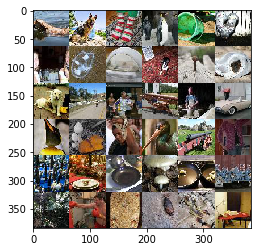

In [73]:
plt.imshow(combine_images(next(fetch)))
plt.show()

------

In [7]:
import tensorflow as tf

In [8]:
class Generator():
    def __init__(self, batch_size, noise_dim = 128):
        self.params = []
        self.params_by_name = {}
        self.noise_dim = noise_dim
        self.name = "Generator"
        self.batch_size = batch_size
        self.CHANNEL_DIM = 128
        self.IMAGE_DIM = 4
        self.KERNEL_SIZE = 5
        self.BETA = 0.9
        self.build()
    
    def set_batch_size(self, batch_size):
        self.batch_size = batch_size
    
    def build(self):
        self.Var_Linear('Linear', self.noise_dim, self.IMAGE_DIM*self.IMAGE_DIM*self.CHANNEL_DIM)
        self.Var_BatchNorm('BN.1', (self.IMAGE_DIM, self.IMAGE_DIM, self.CHANNEL_DIM))
        
        self.Var_Deconv2D('Deconv1', self.CHANNEL_DIM, self.CHANNEL_DIM//2, self.KERNEL_SIZE)
        self.Var_BatchNorm('BN.2', (2*self.IMAGE_DIM, 2*self.IMAGE_DIM, self.CHANNEL_DIM//2))
        
        self.Var_Deconv2D('Deconv2', self.CHANNEL_DIM//2, self.CHANNEL_DIM//4, self.KERNEL_SIZE)
        self.Var_BatchNorm('BN.3', (4*self.IMAGE_DIM, 4*self.IMAGE_DIM, self.CHANNEL_DIM//4))
        
        self.Var_Deconv2D('Deconv3', self.CHANNEL_DIM//4, self.CHANNEL_DIM//4, self.KERNEL_SIZE)
        self.Var_BatchNorm('BN.4', (8*self.IMAGE_DIM, 8*self.IMAGE_DIM, self.CHANNEL_DIM//4))
        
        self.Var_Deconv2D('Deconv4', self.CHANNEL_DIM//4, 3, self.KERNEL_SIZE)
        
    
    def Var_Linear(self, layer_name, input_dim, output_dim):
        with tf.variable_scope(self.name+'.'+layer_name, reuse=tf.AUTO_REUSE):
            W = tf.get_variable('W', [input_dim, output_dim],\
                                initializer=tf.truncated_normal_initializer(stddev=0.02))
            b = tf.get_variable('b', [output_dim], initializer=tf.constant_initializer(0), dtype=tf.float32)
        self.params_by_name[self.name+'.'+layer_name+'.W'] = W
        self.params_by_name[self.name+'.'+layer_name+'.b'] = b
        self.params.append(W)
        self.params.append(b)
        
    def Var_Deconv2D(self, layer_name, input_dim, output_dim, filter_size):
        # Create weights, add them to list, return the operations
        with tf.variable_scope(self.name+'.'+layer_name, reuse=tf.AUTO_REUSE):
            W = tf.get_variable('W', [filter_size, filter_size, output_dim, input_dim],\
                                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.get_variable('b', [output_dim], initializer=tf.constant_initializer(0), dtype=tf.float32)
        self.params_by_name[self.name+'.'+layer_name+'.W'] = W
        self.params_by_name[self.name+'.'+layer_name+'.b'] = b
        self.params.append(W)
        self.params.append(b)
        
    def Var_BatchNorm(self, layer_name, input_shape):
        with tf.variable_scope(self.name+'.'+layer_name, reuse=tf.AUTO_REUSE):
            scale = tf.get_variable('scale', input_shape, \
                                    initializer=tf.constant_initializer(1), dtype=tf.float32)
            offset = tf.get_variable('offset', input_shape, \
                                     initializer=tf.constant_initializer(0), dtype=tf.float32)
            moving_variance = tf.get_variable('moving_variance', input_shape, \
                                    initializer=tf.constant_initializer(1), dtype=tf.float32)
            moving_mean = tf.get_variable('moving_mean', input_shape, \
                                     initializer=tf.constant_initializer(0), dtype=tf.float32)
        self.params_by_name[self.name+'.'+layer_name+'.scale'] = scale
        self.params_by_name[self.name+'.'+layer_name+'.offset'] = offset
        self.params_by_name[self.name+'.'+layer_name+'.moving_mean'] = moving_mean
        self.params_by_name[self.name+'.'+layer_name+'.moving_variance'] = moving_variance
        self.params.append(scale)
        self.params.append(offset)
    
    def Linear(self, layer_name, inputs):
        W = self.params_by_name[self.name+'.'+layer_name+'.W']
        b = self.params_by_name[self.name+'.'+layer_name+'.b']
        return tf.matmul(inputs, W) + b
        
    def Deconv2d(self, layer_name, output_shape, inputs):
        W = self.params_by_name[self.name+'.'+layer_name+'.W']
        b = self.params_by_name[self.name+'.'+layer_name+'.b']
        result = tf.nn.conv2d_transpose(value=inputs, filter=W,\
                                        output_shape=output_shape, strides=[1, 2, 2, 1], padding='SAME') + b
        return result
    
    def BatchNorm(self, layer_name, inputs, is_training):
        scale = self.params_by_name[self.name+'.'+layer_name+'.scale']
        offset = self.params_by_name[self.name+'.'+layer_name+'.offset']
        moving_mean = self.params_by_name[self.name+'.'+layer_name+'.moving_mean']
        moving_variance = self.params_by_name[self.name+'.'+layer_name+'.moving_variance']
        if is_training == True:
            mean, variance = tf.nn.moments(inputs, [0], keep_dims=False)
            moving_mean = self.BETA * moving_mean + (1 - self.BETA) * mean
            moving_variance = self.BETA * moving_variance + (1 - self.BETA) * variance
            return tf.nn.batch_normalization(inputs, mean, variance, offset, scale, 1e-8)
        else:
            return tf.nn.batch_normalization(inputs, moving_mean, moving_variance, offset, scale, 1e-8)
    
    def output(self, noise = None, is_training = True):
        if noise is None:
            noise = tf.random_normal((self.batch_size, self.noise_dim))
        
        X = self.Linear('Linear', noise)
        X = tf.reshape(X, (-1, self.IMAGE_DIM, self.IMAGE_DIM, self.CHANNEL_DIM))
        X = self.BatchNorm('BN.1', X, is_training)
        X = tf.nn.relu(X)
        
        output_shape = (self.batch_size, 2*self.IMAGE_DIM, 2*self.IMAGE_DIM, self.CHANNEL_DIM//2)
        X = self.Deconv2d('Deconv1', output_shape, X)
        X = self.BatchNorm('BN.2', X, is_training)
        X = tf.nn.relu(X)
        
        output_shape = (output_shape[0], output_shape[1]*2, output_shape[2]*2, output_shape[3]//2)
        X = self.Deconv2d('Deconv2', output_shape, X)
        X = self.BatchNorm('BN.3', X, is_training)
        X = tf.nn.relu(X)
        
        output_shape = (output_shape[0], output_shape[1]*2, output_shape[2]*2, output_shape[3])
        X = self.Deconv2d('Deconv3', output_shape, X)
        X = self.BatchNorm('BN.4', X, is_training)
        X = tf.nn.relu(X)
        
        output_shape = (output_shape[0], output_shape[1]*2, output_shape[2]*2, 3)
        X = self.Deconv2d('Deconv4', output_shape, X)
        X = tf.tanh(X)
        
        return X

In [9]:
class Discriminator():
    def __init__(self):
        self.params = []
        self.params_by_name = {}
        self.name = "Discriminator"
        self.CHANNEL_DIM = 32
        self.IMAGE_DIM = 4
        self.KERNEL_SIZE = 5
        self.build()
    
    def build(self):
        self.Var_Conv2D('Conv1', 3, self.CHANNEL_DIM, self.KERNEL_SIZE)
        self.Var_Conv2D('Conv2', self.CHANNEL_DIM, self.CHANNEL_DIM, self.KERNEL_SIZE)
        self.Var_Conv2D('Conv3', self.CHANNEL_DIM, 2*self.CHANNEL_DIM, self.KERNEL_SIZE)
        self.Var_Conv2D('Conv4', 2*self.CHANNEL_DIM, 4*self.CHANNEL_DIM, self.KERNEL_SIZE)
        self.Var_Linear('Linear', self.IMAGE_DIM*self.IMAGE_DIM*4*self.CHANNEL_DIM, 1)
    
    def LeakyReLU(self, x, alpha=0.2):
        return tf.maximum(alpha*x, x)
    
    def Var_Linear(self, layer_name, input_dim, output_dim):
        with tf.variable_scope(self.name+'.'+layer_name, reuse=tf.AUTO_REUSE):
            W = tf.get_variable('W', [input_dim, output_dim],\
                                initializer=tf.truncated_normal_initializer(stddev=0.02))
            b = tf.get_variable('b', [output_dim], initializer=tf.constant_initializer(0), dtype=tf.float32)
        self.params_by_name[self.name+'.'+layer_name+'.W'] = W
        self.params_by_name[self.name+'.'+layer_name+'.b'] = b
        self.params.append(W)
        self.params.append(b)
        
    def Var_Conv2D(self, layer_name, input_dim, output_dim, filter_size):
        # Create weights, add them to list, return the operations
        with tf.variable_scope(self.name+'.'+layer_name, reuse=tf.AUTO_REUSE):
            W = tf.get_variable('W', [filter_size, filter_size, input_dim, output_dim],\
                                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.get_variable('b', [output_dim], initializer=tf.constant_initializer(0), dtype=tf.float32)
        self.params_by_name[self.name+'.'+layer_name+'.W'] = W
        self.params_by_name[self.name+'.'+layer_name+'.b'] = b
        self.params.append(W)
        self.params.append(b)
        
    def Linear(self, layer_name, inputs):
        W = self.params_by_name[self.name+'.'+layer_name+'.W']
        b = self.params_by_name[self.name+'.'+layer_name+'.b']
        return tf.matmul(inputs, W) + b
        
    def Conv2d(self, layer_name, inputs):
        W = self.params_by_name[self.name+'.'+layer_name+'.W']
        b = self.params_by_name[self.name+'.'+layer_name+'.b']
        result = tf.nn.conv2d(inputs, W, [1, 2, 2, 1],padding='SAME') + b
        return result
    
    def output(self, X):
        X = self.Conv2d('Conv1', X)
        X = self.LeakyReLU(X)
        
        X = self.Conv2d('Conv2', X)
        X = self.LeakyReLU(X)
        
        X = self.Conv2d('Conv3', X)
        X = self.LeakyReLU(X)
        
        X = self.Conv2d('Conv4', X)
        X = self.LeakyReLU(X)
        
        X = tf.reshape(X, [-1, self.IMAGE_DIM*self.IMAGE_DIM*4*self.CHANNEL_DIM])
        X = self.Linear('Linear', X)
        return tf.reshape(X, [-1])

In [ ]:
tf.reset_default_graph()

In [10]:
LAMBDA = 10 # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 5 # How many critic iterations per generator iteration
BATCH_SIZE = 64

In [11]:
IMAGE_SHAPE = [None, 64, 64, 3]
real_data_uint = tf.placeholder(tf.uint8, shape=IMAGE_SHAPE)
real_data =  2*((tf.cast(real_data_uint, tf.float32)/255.)-.5)

is_training = tf.placeholder(tf.bool, shape=())
batch_size = tf.placeholder(tf.int32, shape=())

generator = Generator(batch_size)
fake_data = generator.output(is_training=is_training)

discriminator = Discriminator()
disc_real = discriminator.output(real_data)
disc_fake = discriminator.output(fake_data)

gen_params = generator.params
disc_params = discriminator.params

In [12]:
gen_cost = -tf.reduce_mean(disc_fake)
disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

alpha = tf.random_uniform(shape=[batch_size]+IMAGE_SHAPE[1:], minval=0.,maxval=1.)
differences = fake_data - real_data
interpolates = real_data + (alpha*differences)
gradients = tf.gradients(discriminator.output(interpolates), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1, 2, 3]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
disc_cost += LAMBDA*gradient_penalty

gen_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)\
    .minimize(gen_cost, var_list=gen_params)
disc_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)\
    .minimize(disc_cost, var_list=disc_params)

In [ ]:
PREV_ITERS = 0

In [ ]:
disc_losses = []
gen_losses = []
generations = []

In [13]:
saver = tf.train.Saver()

In [ ]:
session = tf.Session()
#session.run(tf.global_variables_initializer())
saver.restore(session, 'models/imgnet-89999')

In [ ]:
fetch_data = get_data(X, BATCH_SIZE)

In [ ]:
ITERS = 5000

In [ ]:
for iteration in range(ITERS):
    for i in range(CRITIC_ITERS):
        _data = next(fetch_data)
        _disc_cost, _ = session.run([disc_cost, disc_train_op], feed_dict={real_data_uint: _data,\
                                                                           is_training: True})
    disc_losses.append(_disc_cost)
    _gen_cost, _ = session.run([gen_cost, gen_train_op], feed_dict={is_training: True})
    if iteration % 100 == 99:
        print("Iteration:  " + str(iteration) + " Discriminator loss " + str(_disc_cost))
        print("Iteration:  " + str(iteration) + " Generator loss " + str(_gen_cost))
    gen_losses.append(_gen_cost)
    if iteration % 500 == 499:
        generations.append(session.run(fake_data))
    if iteration % 5000 == 4999:
        saver.save(session, './models/imgnet', global_step=PREV_ITERS+iteration)
        np.save('./models/imgnet_disc_losses_'+str(PREV_ITERS+iteration), disc_losses)
        np.save('./models/imgnet_gen_losses_'+str(PREV_ITERS +iteration), gen_losses)
        np.save('./models/imgnet_generations_'+str(PREV_ITERS +iteration), generations)
PREV_ITERS += ITERS

In [ ]:
plt.plot(disc_losses)
plt.plot(gen_losses)

In [ ]:
len(generations)

In [ ]:
for i in range(len(generations)):
    indices = np.random.permutation(len(generations[i]))[:36]
    plt.imshow(combine_images(generations[i][indices]/2 + 0.5))
    #plt.savefig("./images/"+str(i)+".png")
    plt.show()

In [ ]:
r = 26
plt.imshow(combine_images(generations[-1][r:r+25]/2 + 0.5))

------

## Test Generations

In [79]:
sess = tf.Session()
saver.restore(sess, './models/imgnet-114999')

INFO:tensorflow:Restoring parameters from ./models/imgnet-114999


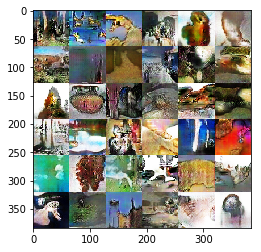

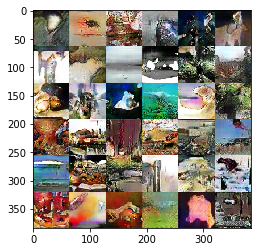

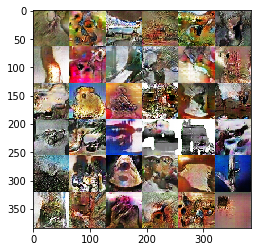

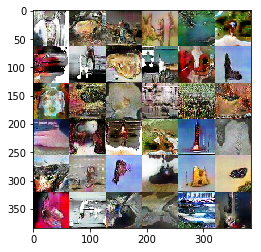

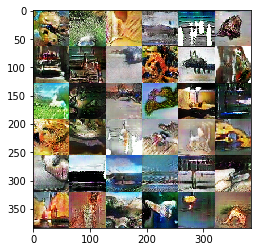

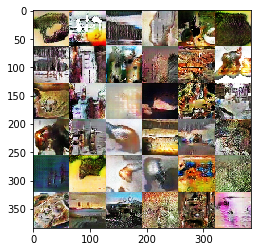

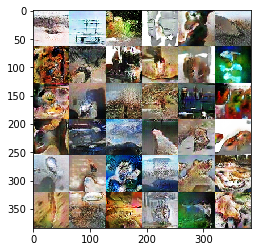

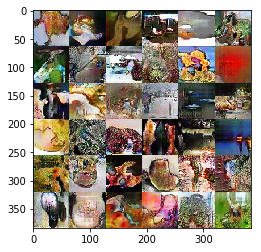

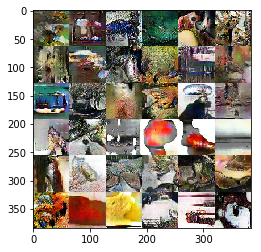

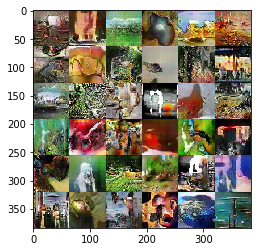

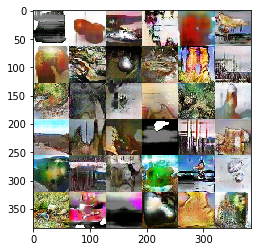

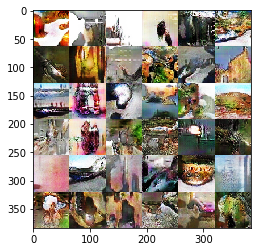

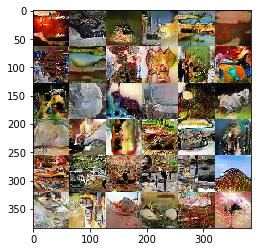

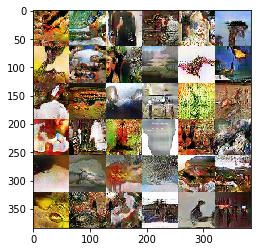

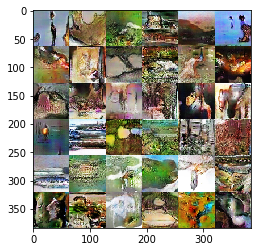

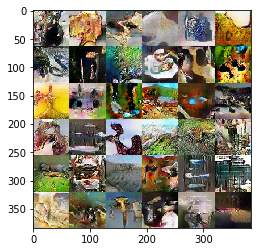

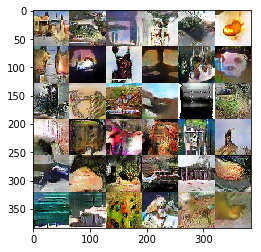

In [84]:
for i in range(3, 20):
    samples = sess.run(fake_data, feed_dict={batch_size:36, is_training:False})
    plt.imshow(combine_images(samples/2 + 0.5))
    plt.savefig("samples/"+str(i)+".png")
    plt.show()